In [4]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from collections import defaultdict

import numpy as np
from scipy.ndimage import binary_dilation
from scipy.ndimage.interpolation import map_coordinates
from dipy.segment.clustering import QuickBundles
from dipy.segment.metric import AveragePointwiseEuclideanMetric
from scipy.spatial import cKDTree
from dipy.tracking.streamline import Streamlines
from dipy.tracking.streamline import transform_streamlines
from dipy.tracking.streamline import values_from_volume
import dipy.stats.analysis as dsa

from tractseg.libs import fiber_utils


#### Custom imports ####
from pprint import pprint
import os
from os.path import join as opj
import numpy as np
import pandas as pd
import sys
import pathlib
from subprocess import call
from actiDep.set_config import set_config,get_HCP_bundle_names
from actiDep.data.loader import Subject, parse_filename, ActiDepFile, Actidep
from actiDep.utils.tools import del_key, upt_dict, add_kwargs_to_cli, run_cli_command, run_mrtrix_command
import SimpleITK as sitk
import json
import tempfile
import glob
import shutil
import ants
import dipy
from dipy.io.stateful_tractogram import Space, StatefulTractogram,Origin
from dipy.io.streamline import save_tractogram, load_tractogram
from time import process_time
import vtk
from dipy.tracking.streamline import transform_streamlines
from scipy.io import loadmat
import nibabel as nib
import pandas as pd
from dipy.io.streamline import load_tractogram, load_trk
import datetime
from dipy.tracking.streamline import orient_by_streamline


/tmp/ipykernel_41672/2864484294.py:9: DeprecationWarning: Please import `map_coordinates` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.interpolation import map_coordinates


In [5]:
ds = Actidep('/home/ndecaux/NAS_EMPENN/share/projects/actidep/bids')

metrics = ds.get_global(pipeline='hcp_association',extension='csv',suffix='mean',bundle='CC1',datatype='metric')

print(metrics)

[<actiDep.data.loader.ActiDepFile object at 0x7f648f4ba630>, <actiDep.data.loader.ActiDepFile object at 0x7f64ac2d3020>, <actiDep.data.loader.ActiDepFile object at 0x7f648f4021b0>, <actiDep.data.loader.ActiDepFile object at 0x7f648f2c6090>, <actiDep.data.loader.ActiDepFile object at 0x7f648efebbc0>, <actiDep.data.loader.ActiDepFile object at 0x7f648ee1c1d0>, <actiDep.data.loader.ActiDepFile object at 0x7f648ee6e5a0>, <actiDep.data.loader.ActiDepFile object at 0x7f648eb5d6d0>, <actiDep.data.loader.ActiDepFile object at 0x7f648e7072c0>, <actiDep.data.loader.ActiDepFile object at 0x7f648ec9be60>, <actiDep.data.loader.ActiDepFile object at 0x7f648e2dc890>, <actiDep.data.loader.ActiDepFile object at 0x7f648dfe0110>, <actiDep.data.loader.ActiDepFile object at 0x7f648e4c0860>, <actiDep.data.loader.ActiDepFile object at 0x7f64ac722f30>, <actiDep.data.loader.ActiDepFile object at 0x7f648da8b380>, <actiDep.data.loader.ActiDepFile object at 0x7f64efdf6570>, <actiDep.data.loader.ActiDepFile object

In [6]:
import pandas as pd
metric_files_dict = {f.get_full_entities()['subject']: f for f in metrics}

#Load all csv files
metric_files = [pd.read_csv(f.path) for f in metrics]
#For all dataframe, add a column with the subject id
for df, f in zip(metric_files, metrics):
    df['subject'] = f.get_full_entities()['subject']
    df['participant_id'] = 'sub-' + df["subject"].astype(str)  # Assuming subject is a string of digits
#Concatenate all dataframes
metrics_df = pd.concat(metric_files, ignore_index=True)

additional_info = pd.read_excel("/home/ndecaux/NAS_EMPENN/share/projects/actidep/bids/participants_full_info.xlsx")
#Merge the additional info with the metrics dataframe using subject <-> participant_id as key
metrics_df = metrics_df.merge(additional_info, on='participant_id', how='left')
metrics_df.head()


,centroid_id,point_id,AD,RD,MD,FA,IFW,IRF,subject,participant_id,...,tmt_ba,mcst_cat,mcst_error,mcst_pers,ami,acp1_scores_cliniques,pc_act1,pc_act2,pc_act3,pc_act4
0,0,0,0.000659,0.000219,0.000366,0.658968,0.276982,0.229548,01021,sub-01021,...,26.0,6.0,2.0,NaN,32.0,0.403571,0.908058,0.594845,0.380249,-0.58149
1,0,1,0.000718,0.000224,0.000388,0.667624,0.241940,0.325371,01021,sub-01021,...,26.0,6.0,2.0,NaN,32.0,0.403571,0.908058,0.594845,0.380249,-0.58149
2,0,2,0.000736,0.000236,0.000403,0.653610,0.239005,0.337710,01021,sub-01021,...,26.0,6.0,2.0,NaN,32.0,0.403571,0.908058,0.594845,0.380249,-0.58149
3,0,3,0.000768,0.000250,0.000423,0.642053,0.237967,0.349838,01021,sub-01021,...,26.0,6.0,2.0,NaN,32.0,0.403571,0.908058,0.594845,0.380249,-0.58149
4,0,4,0.000791,0.000255,0.000433,0.639666,0.244558,0.331193,01021,sub-01021,...,26.0,6.0,2.0,NaN,32.0,0.403571,0.908058,0.594845,0.380249,-0.58149


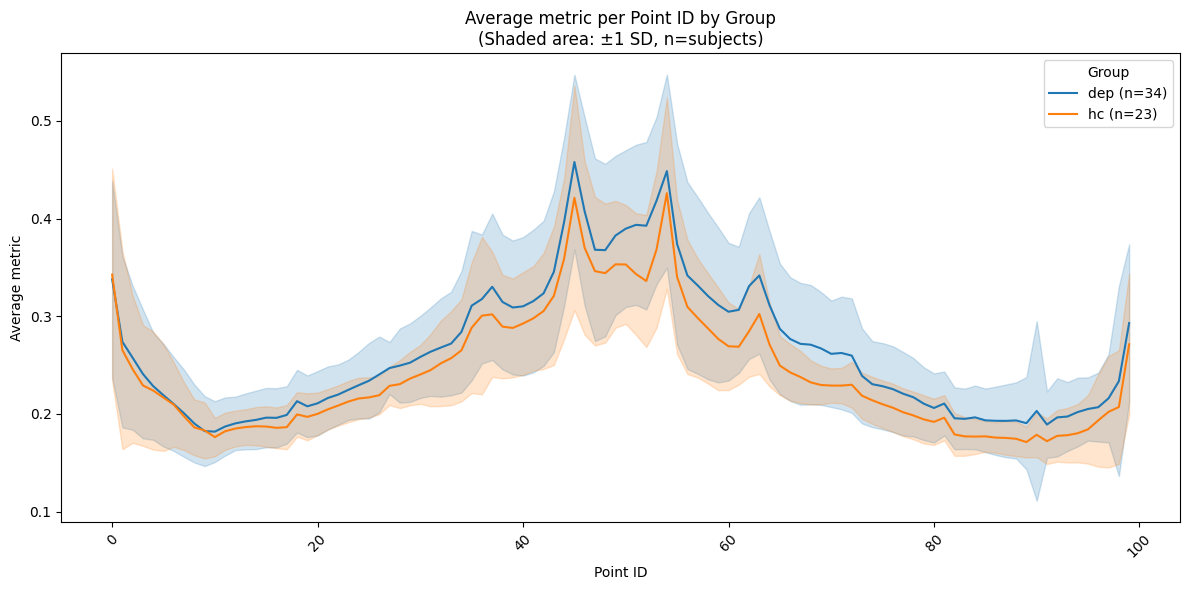

In [7]:
#Plot the average value of metric for each point_id, grouped by column 'group'
import matplotlib.pyplot as plt
import seaborn as sns

metric='IFW'

plt.figure(figsize=(12, 6))
# Plot the mean with standard deviation as shaded area
sns.lineplot(
    data=metrics_df, 
    x='point_id', 
    y=metric, 
    hue='group', 
    errorbar='sd', 
    estimator='mean'
)

# Calculate number of subjects per group for legend
group_counts = metrics_df[['participant_id', 'group']].drop_duplicates().groupby('group').size()
handles, labels = plt.gca().get_legend_handles_labels()
# Update legend labels to include subject count
new_labels = []
for label in labels:
    if label in group_counts:
        new_labels.append(f"{label} (n={group_counts[label]})")
    else:
        new_labels.append(label)
plt.legend(handles=handles, labels=new_labels, title='Group')

plt.title('Average metric per Point ID by Group\n(Shaded area: ±1 SD, n=subjects)')
plt.xlabel('Point ID')
plt.ylabel('Average metric')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [17]:
# Correction des valeurs du metric par régression linéaire sur la colonne 'city' (ou autre variable de nuisance)
import statsmodels.api as sm

metric = 'IFW'  # ou autre nom de colonne de metric
nuisances = ['sex', 'city','age']  # liste des colonnes à régresser (remplacer par les colonnes désirées)

# Encoder chaque colonne de nuisance catégorielle par une valeur entière (pour les colonnes de type object ou category)
for nuisance in nuisances:
    if nuisance in metrics_df.columns:
        if metrics_df[nuisance].dtype == 'object' or str(metrics_df[nuisance].dtype).startswith('category'):
            metrics_df[nuisance + '_int'] = metrics_df[nuisance].astype('category').cat.codes
        else:
            metrics_df[nuisance + '_int'] = metrics_df[nuisance]
    else:
        metrics_df[nuisance + '_int'] = np.nan

# On va corriger chaque valeur du metric pour chaque point_id
metrics_df['metric_corrected'] = np.nan

nuisance_int_cols = [n + '_int' for n in nuisances]

for pid in metrics_df['point_id'].unique():
    df_pid = metrics_df[metrics_df['point_id'] == pid]
    # On vérifie que toutes les colonnes de nuisance existent et ne sont pas toutes nulles
    valid_cols = [col for col in nuisance_int_cols if col in df_pid.columns and df_pid[col].notnull().any()]
    if valid_cols:
        X = df_pid[valid_cols]
        X = sm.add_constant(X)
        y = df_pid[metric]
        model = sm.OLS(y, X, missing='drop').fit()
        # On prend les résidus comme valeurs corrigées
        corrected = model.resid + model.params['const']  # on ajoute la constante pour garder la moyenne
        metrics_df.loc[df_pid.index, 'metric_corrected'] = corrected
    else:
        # Si pas de variable de nuisance, on garde la valeur brute
        metrics_df.loc[df_pid.index, 'metric_corrected'] = df_pid[metric]

# On peut maintenant utiliser 'metric_corrected' pour les plots

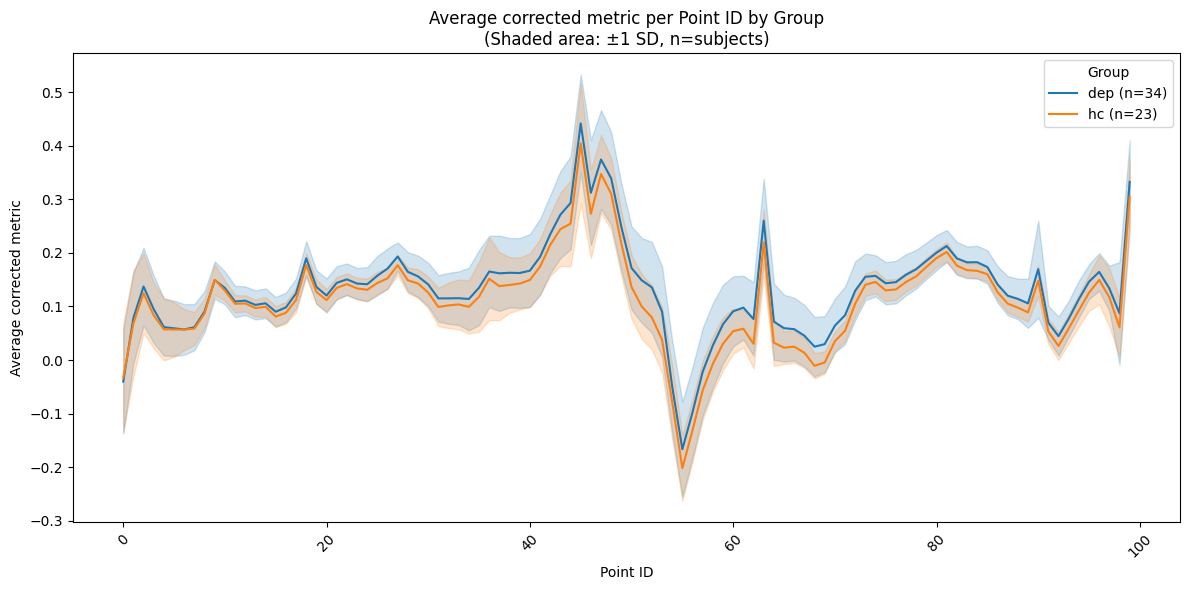

In [16]:
#Plot the average value of corrected metric for each point_id, grouped by column 'group'
import matplotlib.pyplot as plt
import seaborn as sns

classif = 'group'

plt.figure(figsize=(12, 6))
sns.lineplot(
    data=metrics_df, 
    x='point_id', 
    y='metric_corrected', 
    hue=classif, 
    errorbar='sd', 
    estimator='mean'
)
# sns.lineplot(
#     data=metrics_df, 
#     x='point_id', 
#     y= metric, 
#     hue=classif, 
#     errorbar='sd', 
#     estimator='mean',
#     linestyle='--',  # Dotted line for original metric
# )

group_counts = metrics_df[['participant_id', classif]].drop_duplicates().groupby(classif).size()
handles, labels = plt.gca().get_legend_handles_labels()
new_labels = []
for label in labels:
    if label in group_counts:
        new_labels.append(f"{label} (n={group_counts[label]})")
    else:
        new_labels.append(label)
plt.legend(handles=handles, labels=new_labels, title='Group')

plt.title('Average corrected metric per Point ID by Group\n(Shaded area: ±1 SD, n=subjects)')
plt.xlabel('Point ID')
plt.ylabel('Average corrected metric')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()